In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import torch
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

## 1. Ekstrak Dataset


In [4]:
files = zf.ZipFile("dataset-SIBI-Augmentasi.zip",'r')
files.extractall()
files.close()

os.listdir(os.path.join(os.getcwd(),"dataset-SIBI-Augmentasi"))

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

## 2. Membagi dataset ke folder yang berbeda


In [6]:
import os
import shutil
import random

def split_indices(total_files, train_ratio):
    train_size = int(train_ratio * total_files)
    
    # Membagi indeks file menjadi train dan test
    indices = list(range(total_files))
    random.shuffle(indices)
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    return train_indices, test_indices

def move_files(source_files, destination_folder):
    # Memindahkan file ke folder tujuan
    for file in source_files:
        shutil.move(file, destination_folder)

# paths folder dalam dataset
subsets = ['train', 'test']
waste_types = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data', subset, waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

# Memisahkan data menjadi train dan test
for waste_type in waste_types:
    source_folder = os.path.join('dataset-SIBI-Augmentasi', waste_type)
    all_files = os.listdir(source_folder)
    train_ind, test_ind = split_indices(len(all_files), 0.8)  # Sesuaikan rasio train

    # Memindahkan file ke folder train
    train_names = [os.path.join(source_folder, all_files[i]) for i in train_ind]
    train_dest = os.path.join("data", "train", waste_type)
    move_files(train_names, train_dest)

    # Memindahkan file ke folder test
    test_names = [os.path.join(source_folder, all_files[i]) for i in test_ind]
    test_dest = os.path.join("data", "test", waste_type)
    move_files(test_names, test_dest)


In [7]:
## Dapatkan path ke folder dengan gambar
path = Path(os.getcwd())/"data"
path

Path('e:/TUGAS KULIAH/SKRIPSI/Source Code/Python/Preprocessing Data + Train Model/data')

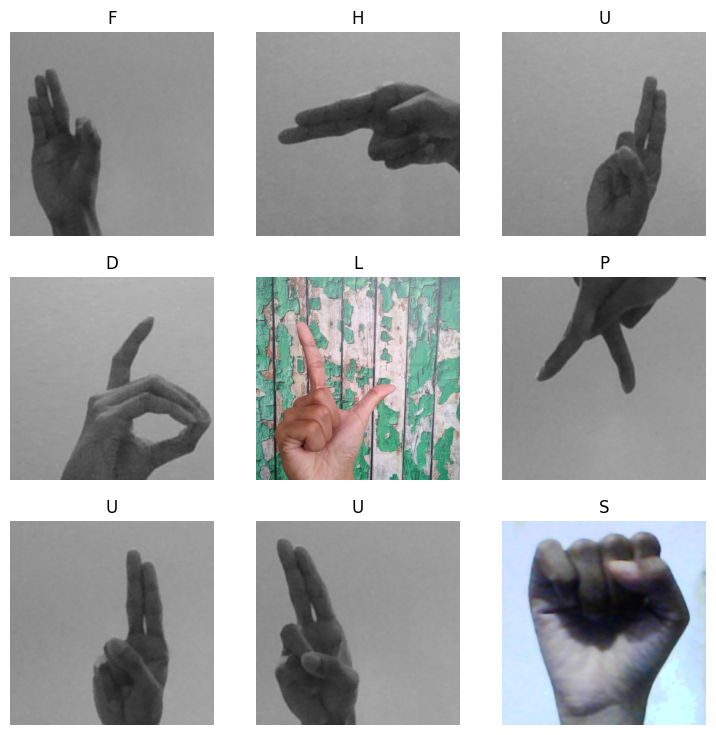

In [17]:
from fastai.vision.all import DataBlock, ImageDataLoaders, ImageBlock, CategoryBlock, get_image_files, RandomSplitter, parent_label, Resize

# Define your DataBlock with Resize transform after item is fetched
data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=parent_label,
                 item_tfms=Resize(460))

# Create DataLoaders
dls = data.dataloaders(path, bs=16)

# Show a batch of data
dls.show_batch()


In [18]:
data

In [19]:
# Assuming you have already created the DataLoaders object 'dls'
print(dls.vocab.o2i)


{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


Here's an example of what the data looks like:

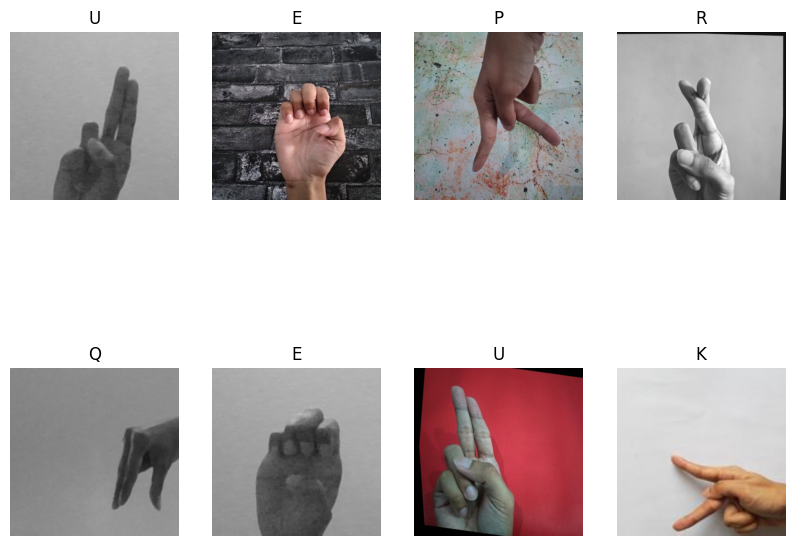

In [20]:
# Assuming 'data' is your DataBlock object
dls = data.dataloaders(path, bs=16) 

# Show a batch of data
dls.show_batch(max_n=8, figsize=(10, 8), nrows=2)


## 3. Model training

In [21]:
from fastai.vision.all import cnn_learner, resnet34
from fastai.vision.models import *

learn = cnn_learner(dls, resnet34, metrics=error_rate)

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


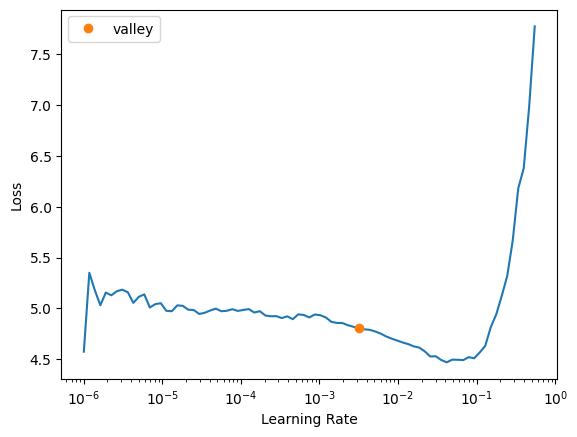

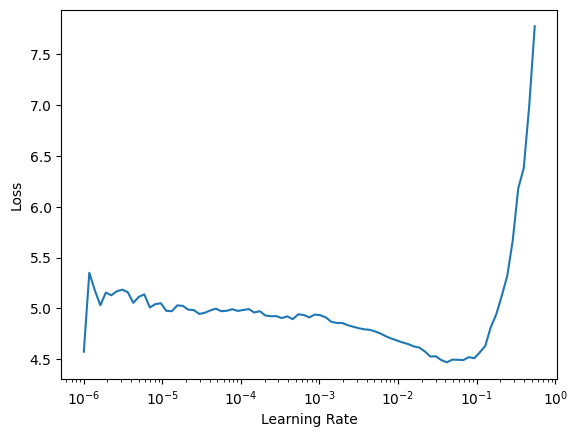

In [22]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot_lr_find(skip_end=5)

### Train Data

In [23]:
learn.fit_one_cycle(10, lr_max=1.13e-03)

KeyboardInterrupt: 

I ran my model for 20 epochs. What's cool about this fitting method is that the learning rate decreases with each epoch, allowing us to get closer and closer to the optimum. At 8.6%, the validation error looks super good... let's see how it performs on the test data though. 

First, we can take a look at which images were most incorrectly classified.

### VIsualizing most incorrect images

In [ ]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()


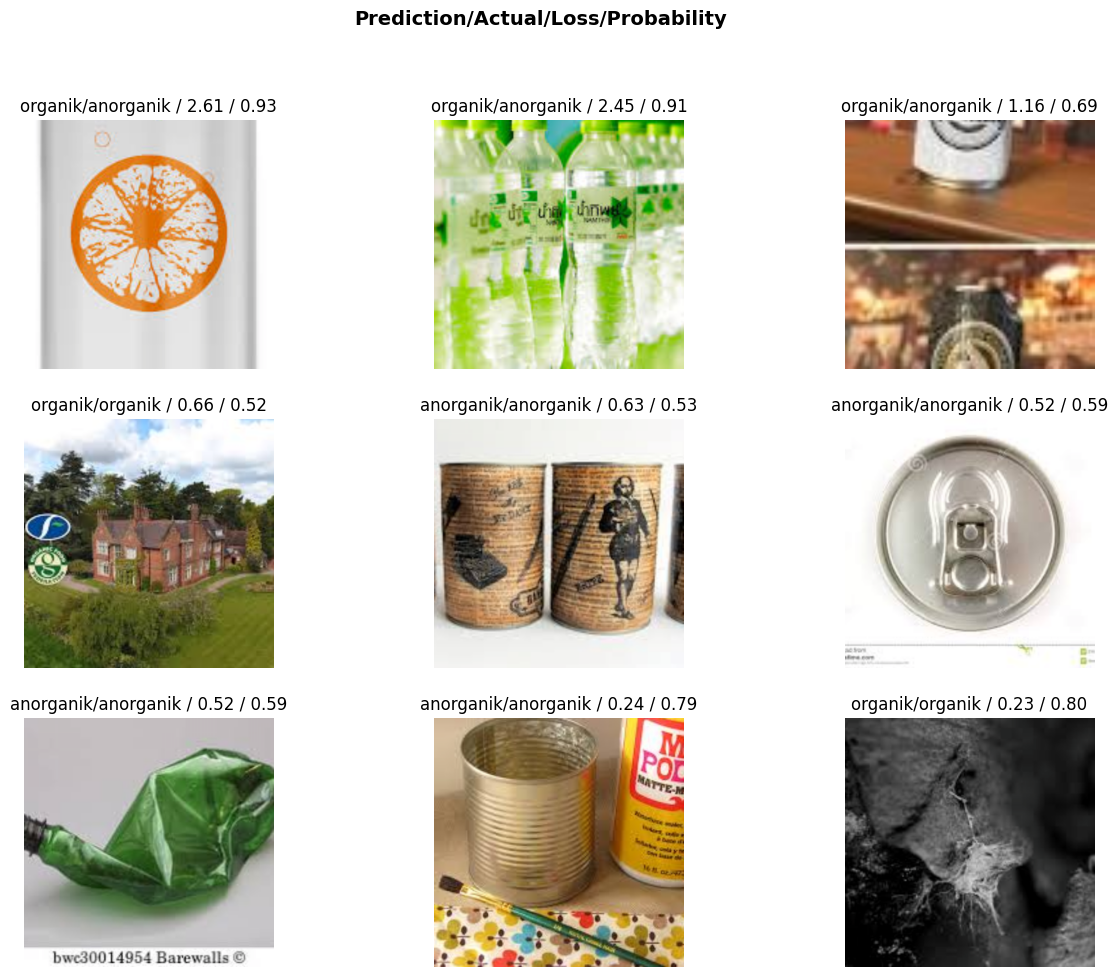

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
learn.export('model.h5')